# 🚗 Car Damage Detection Model Training

This notebook demonstrates the complete process of training a deep learning model for vehicle damage classification using PyTorch. We'll explore different architectures including custom CNN, EfficientNet, and ResNet50 with transfer learning.

## 📚 Import Required Libraries

In [65]:
# Core PyTorch libraries for deep learning
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
import time
import timm

# Data handling and preprocessing
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Visualization and metrics
from matplotlib import pyplot as plt
import numpy as np

## ⚙️ Device Configuration
Setting up the computation device. Using CUDA (GPU) for faster training if available.

In [66]:
# Set device to CUDA if available, otherwise CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Display GPU information if available
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

Using device: cuda
GPU: NVIDIA GeForce RTX 3080 Ti
Memory: 12.9 GB


## 📂 Data Loading and Preprocessing

### Image Transformations
We apply several data augmentation techniques to improve model generalization:
- **RandomHorizontalFlip**: Mirrors images horizontally
- **RandomRotation**: Rotates images by up to 10 degrees
- **ColorJitter**: Adjusts brightness and contrast
- **Resize**: Standardizes image size to 280x280 pixels
- **Normalize**: Uses ImageNet statistics for transfer learning compatibility

In [67]:
# Define comprehensive image transformations for data augmentation
image_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),          # Randomly flip images horizontally
    transforms.RandomRotation(10),              # Rotate images by ±10 degrees
    transforms.ColorJitter(contrast=0.2, brightness=0.2),  # Adjust contrast and brightness
    transforms.Resize((280, 280)),              # Resize all images to 280x280
    transforms.ToTensor(),                      # Convert PIL Image to tensor
    transforms.Normalize(                       # Normalize using ImageNet statistics
        mean=[0.485, 0.456, 0.406],           # RGB channel means
        std=[0.229, 0.224, 0.225]             # RGB channel standard deviations
    )
])

### 📁 Dataset Loading

Loading the vehicle damage dataset from the specified directory structure.
Expected folder structure:

In [68]:
# Set the path to your dataset
data_path = './dataset'

# Load dataset using ImageFolder (automatically creates labels from folder names)
dataset = datasets.ImageFolder(root=data_path, transform=image_transforms)

print(f"Total number of images: {len(dataset)}")
print(f"Number of classes: {len(dataset.classes)}")

Total number of images: 2306
Number of classes: 6


### 🏷️ Class Labels

Display the damage categories that our model will learn to classify.

In [69]:
# Get class names from dataset
class_name = dataset.classes
print("Damage Categories:")
for i, class_label in enumerate(class_name):
    print(f"{i}: {class_label}")

Damage Categories:
0: F_Breakage
1: F_Crushed
2: F_Normal
3: R_Breakage
4: R_Crushed
5: R_Normal


### ✂️ Train-Test Split

Dividing the dataset into training (75%) and testing (25%) sets for model evaluation.

In [70]:
# Calculate split sizes
train_size = int(0.75 * len(dataset))  # 75% for training
test_size = len(dataset) - train_size  # 25% for testing

print(f"Training samples: {train_size}")
print(f"Testing samples: {test_size}")
print(f"Split ratio: {train_size/len(dataset):.1%} train, {test_size/len(dataset):.1%} test")

Training samples: 1729
Testing samples: 577
Split ratio: 75.0% train, 25.0% test


### 🔄 Data Loaders
Creating data loaders for efficient batch processing during training and testing.

In [71]:
# Split dataset randomly
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Set batch size for training
batch_size = 64

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training batches: {len(train_loader)}")
print(f"Testing batches: {len(test_loader)}")

Training batches: 28
Testing batches: 10


### 🔍 Data Shape Inspection

Verify the dimensions of our batched data to ensure correct preprocessing.

In [72]:
# Check the shape of a single batch
for image, label in train_loader:
    print(f"Image batch shape: {image.shape}")  # [batch_size, channels, height, width]
    print(f"Label batch shape: {label.shape}")  # [batch_size]
    break

Image batch shape: torch.Size([64, 3, 280, 280])
Label batch shape: torch.Size([64])


In [73]:
# Check specific sample dimensions
print(f"Sample label: {label[50]}")
print(f"Sample image shape: {image[1].shape}")
label[50], image[1].shape

Sample label: 1
Sample image shape: torch.Size([3, 280, 280])


(tensor(1), torch.Size([3, 280, 280]))

In [74]:
# Check image dimensions after permuting for visualization
print(f"Image shape after permute: {image[1].permute(1,2,0).shape}")
image[1].permute(1,2,0).shape

Image shape after permute: torch.Size([280, 280, 3])


torch.Size([280, 280, 3])

### 🖼️ Sample Image Visualization
Display a sample image from the dataset to verify preprocessing.

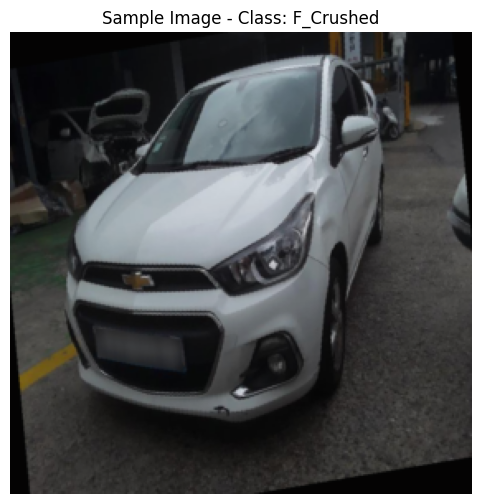

In [75]:
# Display a sample image
# Need to denormalize and permute dimensions for matplotlib
sample_image = image[50].permute(1,2,0)

# Denormalize the image
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])
sample_image = sample_image * std + mean
sample_image = torch.clamp(sample_image, 0, 1)

plt.figure(figsize=(8, 6))
plt.imshow(sample_image)
plt.title(f"Sample Image - Class: {class_name[label[50]]}")
plt.axis('off')
plt.show()

# 🧠 Model Training

## Model 1: Custom CNN Architecture
Building a custom Convolutional Neural Network with:
- 3 Convolutional blocks with ReLU activation and MaxPooling
- Progressive channel increase: 3 → 16 → 32 → 64
- Fully connected layers for classification

In [76]:
class CarDamageClass(nn.Module):
    def __init__(self, num_class):
        super().__init__()
        self.network = nn.Sequential(
            # First conv block: 3 -> 16 channels
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),  # 280x280 -> 140x140
            
            # Second conv block: 16 -> 32 channels
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),  # 140x140 -> 70x70
            
            # Third conv block: 32 -> 64 channels
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            
            # Classifier
            nn.Flatten(),                    # Flatten: 64*70*70 = 313,600
            nn.Linear(64*70*70, 512),       # Hidden layer
            nn.ReLU(),
            nn.Linear(512, num_class)       # Output layer
        )

    def forward(self, x):
        return self.network(x)

In [77]:
# Initialize model, loss function, and optimizer
num_class = len(dataset.classes)

model = CarDamageClass(num_class=num_class).to(device)
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Display model information
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")
model

Total parameters: 160,590,374


CarDamageClass(
  (network): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=313600, out_features=512, bias=True)
    (10): ReLU()
    (11): Linear(in_features=512, out_features=6, bias=True)
  )
)

In [78]:
# Check data dimensions
print(f"Batch size: {image.size(0)}")
print(f"Training dataset size: {len(train_loader.dataset)}")
image.size(0), len(train_loader.dataset)

Batch size: 64
Training dataset size: 1729


(64, 1729)

In [79]:
# Verify image shapes in training loop
for images, labels in train_loader:
    print(f"Image batch shape: {images.shape}")
    break

Image batch shape: torch.Size([64, 3, 280, 280])


### 🔧 Training Function
Comprehensive training function that handles forward pass, loss calculation, backpropagation, and validation.

In [80]:
def train_model(model, criterion, optimizer, epochs=5):
    """
    Train the model and evaluate on test set
    """
    start = time.time()
    
    for epoch in range(epochs):
        model.train()  # Set to training mode
        running_loss = 0.0
        
        for batch, (images, labels) in enumerate(train_loader):
            # Move data to device
            images, labels = images.to(device), labels.to(device)

            # Zero gradients from previous iteration
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Print progress every 10 batches
            if (batch + 1) % 10 == 0:
                print(f'Batch: {batch + 1}, Epoch: {epoch + 1}, Loss: {loss.item():.2f}')

            running_loss += loss.item() * images.size(0)

        # Calculate average loss for epoch
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch [{epoch + 1}/{epochs}], Avg Loss: {epoch_loss:.4f}')

    # Validation phase
    model.eval()  # Set to evaluation mode
    correct = 0
    total = 0
    all_labels, all_prediction = [], []
    
    with torch.no_grad():  # Disable gradient computation
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_prediction.extend(predicted.cpu().numpy())

    # Display results
    accuracy = 100 * correct / total
    print(f'------ Validation Accuracy: {accuracy:.2f}%')

    end = time.time()
    print(f'Execution time: {(end - start):.2f} seconds')

    return all_labels, all_prediction

### 🚀 Training Basic CNN Model

Training the custom CNN model for 10 epochs.

In [81]:
# Train the basic CNN model
print("Training Basic CNN Model...")
all_labels, all_prediction = train_model(model, criterion, optimizer, epochs=10)

Training Basic CNN Model...
Batch: 10, Epoch: 1, Loss: 1.79
Batch: 20, Epoch: 1, Loss: 1.66
Epoch [1/10], Avg Loss: 3.2629
Batch: 10, Epoch: 2, Loss: 1.41
Batch: 20, Epoch: 2, Loss: 1.66
Epoch [2/10], Avg Loss: 1.4528
Batch: 10, Epoch: 3, Loss: 1.62
Batch: 20, Epoch: 3, Loss: 1.32
Epoch [3/10], Avg Loss: 1.3680
Batch: 10, Epoch: 4, Loss: 1.32
Batch: 20, Epoch: 4, Loss: 1.28
Epoch [4/10], Avg Loss: 1.2086
Batch: 10, Epoch: 5, Loss: 1.33
Batch: 20, Epoch: 5, Loss: 1.07
Epoch [5/10], Avg Loss: 1.1373
Batch: 10, Epoch: 6, Loss: 1.03
Batch: 20, Epoch: 6, Loss: 0.97
Epoch [6/10], Avg Loss: 1.0455
Batch: 10, Epoch: 7, Loss: 1.17
Batch: 20, Epoch: 7, Loss: 0.92
Epoch [7/10], Avg Loss: 1.1294
Batch: 10, Epoch: 8, Loss: 0.99
Batch: 20, Epoch: 8, Loss: 0.89
Epoch [8/10], Avg Loss: 1.0161
Batch: 10, Epoch: 9, Loss: 1.14
Batch: 20, Epoch: 9, Loss: 0.91
Epoch [9/10], Avg Loss: 0.9836
Batch: 10, Epoch: 10, Loss: 1.13
Batch: 20, Epoch: 10, Loss: 0.84
Epoch [10/10], Avg Loss: 1.0385
------ Validation A

## Model 2: Regularized CNN Architecture
Improved CNN with regularization techniques:
- **Batch Normalization**: Stabilizes training
- **Dropout**: Prevents overfitting

In [82]:
class CarDamageClassRegular(nn.Module):
    def __init__(self, num_class):
        super().__init__()
        self.network = nn.Sequential(
            # First conv block with BatchNorm
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),  # Batch normalization
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            
            # Second conv block with BatchNorm
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            
            # Third conv block with BatchNorm
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            # Classifier with dropout
            nn.Flatten(),
            nn.Linear(64*70*70, 512),
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout for regularization
            nn.Linear(512, num_class)
        )

    def forward(self, x):
        return self.network(x)

In [83]:
# Initialize and train regularized model
num_class = len(dataset.classes)

model = CarDamageClassRegular(num_class=num_class).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Training Regularized CNN Model...")
all_labels, all_prediction = train_model(model, criterion, optimizer, epochs=10)

Training Regularized CNN Model...
Batch: 10, Epoch: 1, Loss: 35.91
Batch: 20, Epoch: 1, Loss: 11.29
Epoch [1/10], Avg Loss: 33.5287
Batch: 10, Epoch: 2, Loss: 1.58
Batch: 20, Epoch: 2, Loss: 1.71
Epoch [2/10], Avg Loss: 1.7301
Batch: 10, Epoch: 3, Loss: 1.56
Batch: 20, Epoch: 3, Loss: 1.37
Epoch [3/10], Avg Loss: 1.5125
Batch: 10, Epoch: 4, Loss: 1.39
Batch: 20, Epoch: 4, Loss: 1.31
Epoch [4/10], Avg Loss: 1.4723
Batch: 10, Epoch: 5, Loss: 1.28
Batch: 20, Epoch: 5, Loss: 1.45
Epoch [5/10], Avg Loss: 1.3884
Batch: 10, Epoch: 6, Loss: 1.50
Batch: 20, Epoch: 6, Loss: 1.54
Epoch [6/10], Avg Loss: 1.3354
Batch: 10, Epoch: 7, Loss: 1.26
Batch: 20, Epoch: 7, Loss: 1.03
Epoch [7/10], Avg Loss: 1.2729
Batch: 10, Epoch: 8, Loss: 1.25
Batch: 20, Epoch: 8, Loss: 1.24
Epoch [8/10], Avg Loss: 1.2484
Batch: 10, Epoch: 9, Loss: 1.19
Batch: 20, Epoch: 9, Loss: 1.28
Epoch [9/10], Avg Loss: 1.3005
Batch: 10, Epoch: 10, Loss: 1.30
Batch: 20, Epoch: 10, Loss: 1.22
Epoch [10/10], Avg Loss: 1.2596
------ Val

### Model 3: Transfer Learning with EfficientNetV2
Using pre-trained EfficientNet and fine-tuning for car damage classification.

In [84]:
# Explore EfficientNet architecture
model = models.efficientnet_v2_m(pretrained=True)
print(f"EfficientNet classifier input features: {model.classifier[1].in_features}")
model.classifier[1].in_features

C:\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_M_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_M_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet classifier input features: 1280


1280

In [85]:
class CarDamageClassEfficent(nn.Module):
    def __init__(self, num_class):
        super().__init__()
        # Load pre-trained EfficientNet-B0
        self.model = models.efficientnet_b0(weights='DEFAULT')

        # Freeze all parameters
        for param in self.model.parameters():
            param.requires_grad = False

        # Get input features for classifier
        in_features = self.model.classifier[1].in_features

        # Replace classifier
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, num_class)
        )

    def forward(self, x):
        return self.model(x)

In [86]:
# Train EfficientNet model
model = CarDamageClassEfficent(num_class=num_class).to(device)
criterion = nn.CrossEntropyLoss()
# Only train classifier parameters
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

print("Training EfficientNet Model...")
train_model(model, criterion, optimizer, epochs=10)

Training EfficientNet Model...
Batch: 10, Epoch: 1, Loss: 1.65
Batch: 20, Epoch: 1, Loss: 1.42
Epoch [1/10], Avg Loss: 1.5747
Batch: 10, Epoch: 2, Loss: 1.28
Batch: 20, Epoch: 2, Loss: 1.13
Epoch [2/10], Avg Loss: 1.2303
Batch: 10, Epoch: 3, Loss: 1.06
Batch: 20, Epoch: 3, Loss: 1.03
Epoch [3/10], Avg Loss: 1.0948
Batch: 10, Epoch: 4, Loss: 1.11
Batch: 20, Epoch: 4, Loss: 0.96
Epoch [4/10], Avg Loss: 0.9963
Batch: 10, Epoch: 5, Loss: 0.93
Batch: 20, Epoch: 5, Loss: 0.99
Epoch [5/10], Avg Loss: 0.9511
Batch: 10, Epoch: 6, Loss: 0.84
Batch: 20, Epoch: 6, Loss: 0.88
Epoch [6/10], Avg Loss: 0.9008
Batch: 10, Epoch: 7, Loss: 0.85
Batch: 20, Epoch: 7, Loss: 0.85
Epoch [7/10], Avg Loss: 0.8845
Batch: 10, Epoch: 8, Loss: 0.91
Batch: 20, Epoch: 8, Loss: 0.76
Epoch [8/10], Avg Loss: 0.8653
Batch: 10, Epoch: 9, Loss: 0.84
Batch: 20, Epoch: 9, Loss: 0.95
Epoch [9/10], Avg Loss: 0.8511
Batch: 10, Epoch: 10, Loss: 0.84
Batch: 20, Epoch: 10, Loss: 0.93
Epoch [10/10], Avg Loss: 0.8345
------ Validatio

([np.int64(3),
  np.int64(3),
  np.int64(5),
  np.int64(0),
  np.int64(1),
  np.int64(2),
  np.int64(5),
  np.int64(3),
  np.int64(0),
  np.int64(3),
  np.int64(0),
  np.int64(0),
  np.int64(2),
  np.int64(1),
  np.int64(3),
  np.int64(0),
  np.int64(3),
  np.int64(4),
  np.int64(3),
  np.int64(5),
  np.int64(2),
  np.int64(2),
  np.int64(3),
  np.int64(1),
  np.int64(4),
  np.int64(4),
  np.int64(5),
  np.int64(0),
  np.int64(2),
  np.int64(2),
  np.int64(4),
  np.int64(4),
  np.int64(2),
  np.int64(0),
  np.int64(1),
  np.int64(2),
  np.int64(3),
  np.int64(1),
  np.int64(0),
  np.int64(0),
  np.int64(2),
  np.int64(0),
  np.int64(4),
  np.int64(3),
  np.int64(5),
  np.int64(4),
  np.int64(1),
  np.int64(3),
  np.int64(4),
  np.int64(5),
  np.int64(0),
  np.int64(4),
  np.int64(4),
  np.int64(0),
  np.int64(2),
  np.int64(2),
  np.int64(2),
  np.int64(1),
  np.int64(0),
  np.int64(2),
  np.int64(2),
  np.int64(2),
  np.int64(2),
  np.int64(0),
  np.int64(4),
  np.int64(1),
  np.int64

### Model 4: Transfer Learning with ResNet50
Best performing model using ResNet50 with partial fine-tuning.

In [87]:
class CarDamageClassResNet50(nn.Module):
    def __init__(self, num_class, drop_out):
        super().__init__()
        # Load pre-trained ResNet50
        self.model = models.resnet50(weights='DEFAULT')

        # Freeze all parameters initially
        for param in self.model.parameters():
            param.requires_grad = False

        # Unfreeze layer4 for fine-tuning
        for param in self.model.layer4.parameters():
            param.requires_grad = True

        # Replace classifier
        self.model.classifier = nn.Sequential(
            nn.Dropout(drop_out),
            nn.Linear(self.model.fc.in_features, num_class)
        )

    def forward(self, x):
        return self.model(x)

### ⚙️ Hyperparameter Tuning Results
After experimentation, optimal parameters:
- **Dropout**: 0.2
- **Learning Rate**: 0.005
- **Optimizer**: AdamW

In [88]:
# Train ResNet50 with optimal hyperparameters
model = CarDamageClassResNet50(num_class, drop_out=0.2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=0.005)

print("Training ResNet50 Model...")
all_labels, all_prediction = train_model(model, criterion, optimizer, epochs=10)

Training ResNet50 Model...
Batch: 10, Epoch: 1, Loss: 0.94
Batch: 20, Epoch: 1, Loss: 0.56
Epoch [1/10], Avg Loss: 1.3973
Batch: 10, Epoch: 2, Loss: 0.59
Batch: 20, Epoch: 2, Loss: 0.37
Epoch [2/10], Avg Loss: 0.5020
Batch: 10, Epoch: 3, Loss: 0.27
Batch: 20, Epoch: 3, Loss: 0.23
Epoch [3/10], Avg Loss: 0.3579
Batch: 10, Epoch: 4, Loss: 0.23
Batch: 20, Epoch: 4, Loss: 0.18
Epoch [4/10], Avg Loss: 0.2495
Batch: 10, Epoch: 5, Loss: 0.23
Batch: 20, Epoch: 5, Loss: 0.20
Epoch [5/10], Avg Loss: 0.2156
Batch: 10, Epoch: 6, Loss: 0.16
Batch: 20, Epoch: 6, Loss: 0.27
Epoch [6/10], Avg Loss: 0.2183
Batch: 10, Epoch: 7, Loss: 0.21
Batch: 20, Epoch: 7, Loss: 0.12
Epoch [7/10], Avg Loss: 0.1968
Batch: 10, Epoch: 8, Loss: 0.21
Batch: 20, Epoch: 8, Loss: 0.15
Epoch [8/10], Avg Loss: 0.1922
Batch: 10, Epoch: 9, Loss: 0.10
Batch: 20, Epoch: 9, Loss: 0.12
Epoch [9/10], Avg Loss: 0.1588
Batch: 10, Epoch: 10, Loss: 0.05
Batch: 20, Epoch: 10, Loss: 0.10
Epoch [10/10], Avg Loss: 0.1304
------ Validation Ac

# 📊 Model Evaluation

## Classification Report
Detailed performance metrics for each damage class.

In [90]:
# Generate classification report
from sklearn.metrics import classification_report

report = classification_report(all_labels, all_prediction, target_names=class_name)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

  F_Breakage       0.84      0.92      0.88       130
   F_Crushed       0.83      0.75      0.79        91
    F_Normal       0.90      0.93      0.91       122
  R_Breakage       0.72      0.81      0.76        83
   R_Crushed       0.72      0.63      0.67        75
    R_Normal       0.82      0.76      0.79        76

    accuracy                           0.82       577
   macro avg       0.81      0.80      0.80       577
weighted avg       0.82      0.82      0.82       577



## 🔍 Confusion Matrix
Visual representation of model predictions vs actual labels.

<Figure size 1000x800 with 0 Axes>

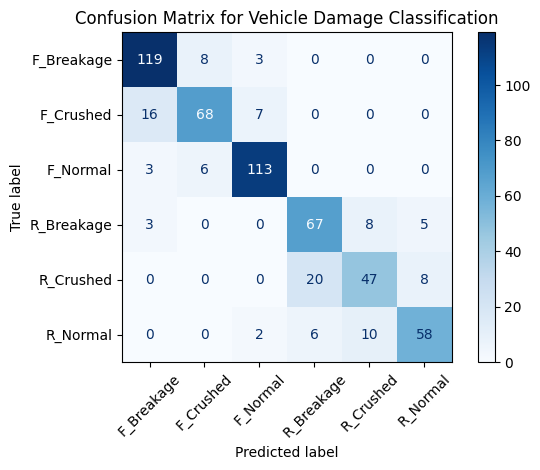

In [91]:
# Create confusion matrix
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(all_labels, all_prediction, labels=np.arange(num_class))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_name)

plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix for Vehicle Damage Classification")
plt.tight_layout()
plt.show()

### 💾 Export Model
Save the trained model for deployment.

In [92]:
# Save the trained model
torch.save(model.state_dict(), 'saved_model.pth')
print("Model saved as 'saved_model.pth'")
print("Model ready for deployment!")

Model saved as 'saved_model.pth'
Model ready for deployment!
